In [114]:
from glob import glob
import json, datetime, time, os, random

%matplotlib inline
from matplotlib import pyplot as plt

import scipy
from tslearn import metrics as tsm

from scipy import ndimage, signal
import scipy.spatial.distance as distance
from scipy.spatial.distance import euclidean,pdist, squareform, cdist
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

import numpy as np
from numpy.lib.stride_tricks import as_strided
np.set_printoptions(precision=3, suppress=True)  # suppress scientific float notation

import pandas as pd
import os, json, platform
import pylab as pl
from pprint import pprint

In [115]:
def get_file(folder, prefix):
    user = os.path.basename(folder)
    files = glob(folder + "/"+prefix+"*.json")
    if len(files) == 0:
        print("File not found", prefix, 'in', folder)
        return None
    else: 
        with open(files[0], 'r') as f: 
            contents = json.load(f)
            return contents, files[0]
        
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

def visualize_codebook_freq(uf):
    pl.rcParams['figure.figsize'] = [8, 7]
    fig, axs = pl.subplots(len(uf.keys()), 1, sharex=True)        
    for i, u in enumerate(uf):
        visualize_hist(u, uf[u], axs[i])

    pl.show()

def visualize_hist(u, data, ax):
    N = n_clusters
    cm = plt.get_cmap("Set3")
    colors = [cm(i) for i in np.linspace(0, 1, N+1)]
    pos = np.arange(N)
    
    c, f = data
    cf = zip(c,f)
    pl.title(u)
    width = 1.0     # gives histogram aspect to the bar diagram
    for d in cf:
        c, f = d
        ax.bar(c, f, width, color=colors[c])

def visualize_codeword(ss, ax):
    N = WORD_SHAPE[0]
    ss = ss.reshape(WORD_SHAPE)
    cm = plt.get_cmap("Set3")
    colors = [cm(i) for i in np.linspace(0, 0.9, N)]
    for i in range(0, N):
        ax.plot(ss[i], color=colors[i])
        
def visualize_codebook(sss, subplot=False):
    if subplot: 
        pl.rcParams['figure.figsize'] = [8, 7]
        fig, axs = pl.subplots(len(sss), 1, sharex=True)        
        for i, ss in enumerate(sss):
            visualize_codeword(ss, axs[i])
    else:
        for ss in sss:
            visualize_codeword(ss, pl)
    pl.show()
def freq(a):
    return np.unique(a, return_counts=True)
    
    
# DISTANCE METRICS
# Similarity Distance
def EuclideanDistance(t1, t2):
    return np.sqrt(np.sum((t1-t2)**2))

# Dynamic Time Warping Distance
def DTWDistance(s1, s2):
    # Initialize distance matrix (nxn), pad filling with inf  
    DTW= {}
    n1 = range(len(s1))
    n2 = range(len(s2))
    for i in n1:
        DTW[(i, -1)] = float('inf')
    for i in n2:
        DTW[(-1, i)] = float('inf')
    DTW[(-1, -1)] = 0
    
    # Compute the distances (O(nm) time)
    for i in n1:
        for j in n2:
            dist = (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)], DTW[(i, j-1)], DTW[(i-1, j-1)])
    return np.sqrt(DTW[len(s1)-1, len(s2)-1])
def DTWDistanceD(t1, t2):
    arr = []
    for i in range(0, t1.shape[0]):
        arr.append(DTWDistance(t1[i], t2[i]))
    return sum(arr)

def DTWDistance2D(t1, t2):
    t1 = t1.reshape(WORD_SHAPE)
    t2 = t2.reshape(WORD_SHAPE)
    arr = []
    for i in range(0, t1.shape[0]):
        arr.append(DTWDistance(t1[i], t2[i]))
    return sum(arr)

def sample_sss(A, n):
    return A[np.random.choice(A.shape[0], n, replace=False), :]

def dtw2(a, b):
    a = a.reshape(WORD_SHAPE)
    b = b.reshape(WORD_SHAPE)
    return tsm.dtw(a, b)

# LOAD DATA INTO MEMORY

`
meta = {
    "L": L,
    "word_shape": word_shape,
    "description": "Accelerometer data for 2 users.",
    "users": users, 
    "features": features, 
    "subsequences": sss.tolist()
}
`

In [116]:
DATASET_ROOT = "irb/datasets"
contents, f = get_file(DATASET_ROOT, "pacc_for_2")
WORD_SHAPE = tuple(contents["word_shape"])
sss = np.array(contents["subsequences"])
USERS = np.array(contents["users"])
feat = np.array(contents["features"])
BOUNDS = np.array(contents["bounds"])

print(os.path.basename(f), ",".join(feat), USERS)
print("(n=%s, %s)" % (sss.shape))
print("word_shape --> features=%s, L=%s)" % (WORD_SHAPE))

('pacc_for_2.json', u'phasic', array([113, 411]))
(n=1952, 10)
word_shape --> features=1, L=10)


# GREEDY K-CENTER SAMPLING

In [117]:
def sample_kcenters_pdist(words, kcenters, cull_threshold=100):
    print("WORDS", words.shape[0], "CENTERS", len(kcenters))
    if len(words) <= 1: 
        return np.array(kcenters)
    
    dtw_along_axis = np.vectorize(dtw2, signature='(n),(m)->()')
    dists = dtw_along_axis(words, kcenters[-1])
    
    idx = np.argsort(dists)
    kcenters.append(words[idx[-1]])    
    dists = np.sort(dists)
    cull_at = np.argmax(dists>cull_threshold)
    cull_indices = idx[:cull_at]
    cull_indices = np.append(cull_indices, idx[-1])
    words = np.delete(words, cull_indices, 0)
    return np.array(sample_kcenters_pdist(words, kcenters, cull_threshold))
    

In [118]:
CULL_THRESHOLD = 80
SAMPLE_PROP = 1.0 # Sample X% of the subsequence dataset
SAMPLE_SIZE = int(sss.shape[0] * SAMPLE_PROP)
FIRST_CENTER = random.randint(0,SAMPLE_SIZE)
print(sss.shape, SAMPLE_SIZE)
code_sample = sample_sss(sss, SAMPLE_SIZE)
seed = code_sample[FIRST_CENTER]
code_sample = np.delete(code_sample, FIRST_CENTER, 0)

((1952, 10), 1952)


In [119]:
centers = sample_kcenters_pdist(code_sample, [seed], CULL_THRESHOLD)
print(centers.shape)

('WORDS', 1951, 'CENTERS', 1)
('WORDS', 37, 'CENTERS', 2)
('WORDS', 24, 'CENTERS', 3)
('WORDS', 0, 'CENTERS', 4)
(4, 10)


# HIEARCHICAL CLUSTERING

In [120]:
# generate the linkage matrix
Z = linkage(sss, method='complete', metric=dtw2)

In [121]:
# set cut-off to 50
max_d = 800  # max_d as in max_distance
print(centers.shape)

(4, 10)


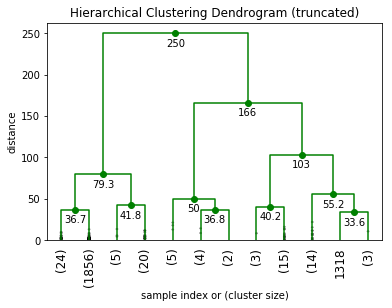

In [122]:
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above= 0.4,  # useful in small plots so annotations don't overlap
    max_d=max_d,
)
plt.show()


# Assembling the codebook

('Samples ', 1952)
('Clusters found', 20)
('P1', (24, 10))
('P2', (1856, 10))
('P3', (5, 10))
('P4', (9, 10))
('P5', (11, 10))
('P6', (3, 10))
('P7', (1, 10))
('P8', (1, 10))
('P9', (4, 10))
('P10', (1, 10))
('P11', (1, 10))
('P12', (3, 10))
('P13', (11, 10))
('P14', (4, 10))
('P15', (5, 10))
('P16', (6, 10))
('P17', (3, 10))
('P18', (2, 10))
('P19', (1, 10))
('P20', (1, 10))


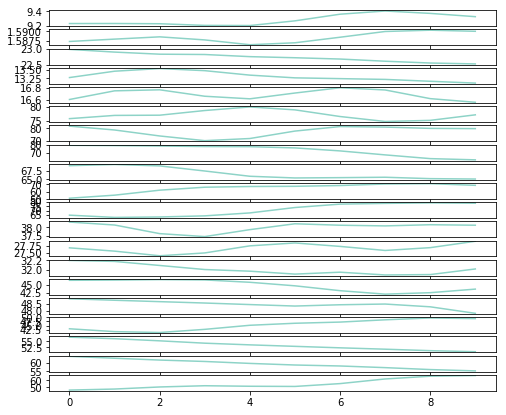

In [123]:
centers = sss
# clusters = fcluster(Z, max_d, criterion='distance')
clusters = fcluster(Z, 20, criterion='maxclust')
print("Samples ", len(centers))
n_clusters = np.max(clusters)
print("Clusters found", n_clusters)

codebook = {}
for i in range(0, len(clusters)):
    cluster_id = clusters[i]
    if not cluster_id in codebook:
        codebook[cluster_id] = []
    codebook[cluster_id].append(centers[i])

for k in codebook:
    codeset = np.array(codebook[k])
    print("P"+str(k), codeset.shape)

    codeset = np.average(codeset, 0)
    codebook[k] = codeset
    
codebook = codebook.values()

visualize_codebook(codebook, subplot=True)


# Applying the codebook

In [124]:

# activity = sss.reshape(1562, 300)[15:]
activity = sss
cb = np.array(list(codebook))#.reshape(3, 300)
print(cb.shape)

result = []
for i, window in enumerate(activity):
#     print(i, "out of", activity.shape[0])
#     print(cb.shape, activity.shape, window.shape, [dtw2(codeword, window) for codeword in cb])
    codeword = np.argmin([dtw2(codeword, window) for codeword in cb])
#     print(codeword)
    result.append(codeword + 1)          

(20, 10)


In [125]:
arr = np.array(result)
sizes = []
for i in range(0, len(BOUNDS)-1):
    start = BOUNDS[i]
    end = BOUNDS[i+1]
    sizes.append(end-start)
tn = max(sizes)

results = np.full((len(BOUNDS) - 1, tn), 0)

u_freq = {}
for i in range(0, len(BOUNDS)-1):
    start = BOUNDS[i]
    end = BOUNDS[i+1]
    u_activity = arr[start:end]
    u_freq[USERS[i]] = freq(u_activity)
    results[i] = np.pad(u_activity, (0, tn - u_activity.shape[0]), 'constant')


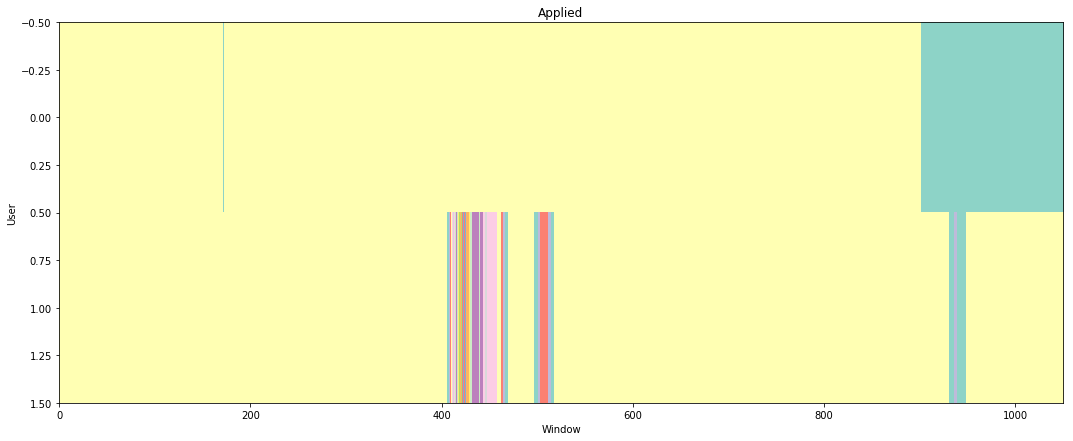

[113 411]


In [126]:
pl.rcParams['figure.figsize'] = [18, 7]
pl.imshow(results, cmap='Set3', interpolation='nearest', aspect='auto')
pl.title("Applied")
pl.ylabel("User")
pl.xlabel("Window")
pl.show()
print(USERS)

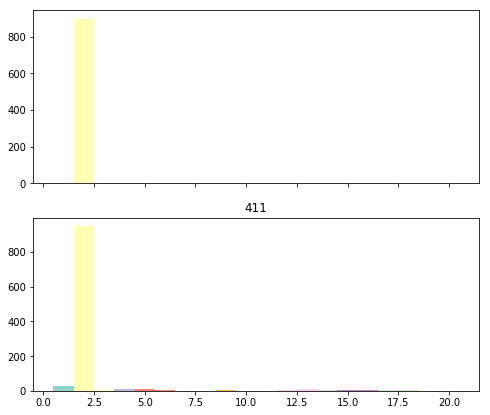

In [127]:
visualize_codebook_freq(u_freq)

# Notes

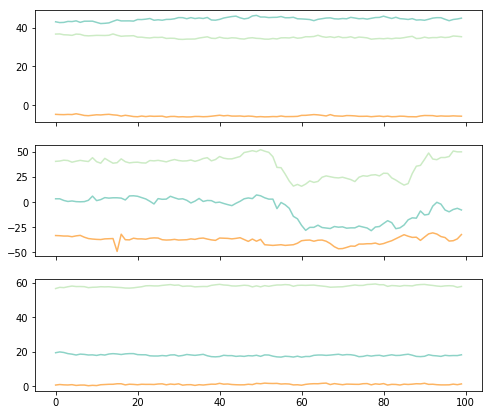

In [40]:
cb = np.array(list(codebook))
visualize_codebook(cb, subplot=True)

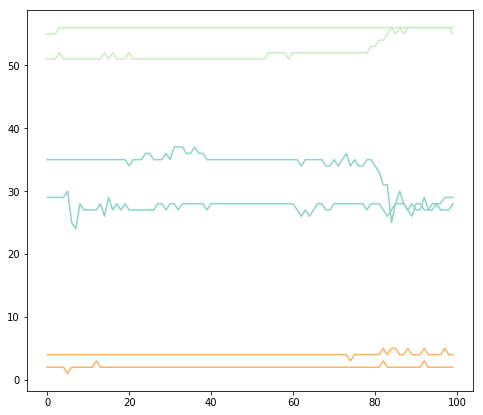

In [104]:
a = sss[0]
b = sss[10]
d2 = DTWDistance2D(a, b)
visualize_codebook([a, b], subplot=False)



In [69]:
def sample_kcenters(words, kcenters, cull_threshold=100):
#     print("WORDS", words.shape[0], "CENTERS", len(kcenters))
    
    if len(words) <= 1: 
        return np.array(kcenters)
    
    n = words.shape[0]
    dist = [dtw2(kcenters[-1], words[i]) for i in range(0, n)]
    dists = np.array(dist)
    
    idx = np.argsort(dists)
    kcenters.append(words[idx[-1]])    
    dists = np.sort(dists)
    cull_at = np.argmax(dists>cull_threshold)
    
    cull_indices = idx[:cull_at]
    cull_indices = np.append(cull_indices, idx[-1])
    words = np.delete(words, cull_indices, 0)
    
    return np.array(sample_kcenters(words, kcenters))

In [75]:
centers = sample_kcenters(code_sample, [seed], CULL_THRESHOLD)